## Hierarchical clustering
From the Clustering notebook I found out that the best result is returned with hierarchical clustering so here I will try to implement

In [1]:
import math
import pandas as pandas
import numpy as np
import matplotlib
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from math import floor
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data = pandas.read_json("../data/water_loss_data_set_1.json")

data = data[(data.timeStamp != "0000-00-00 00:00:00" ) & (data.timeStamp != "2000-01-01 00:00:00")] 
data = data[(data.tot1 != 0 ) & (data.analog2 != 0)]
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data["timeStamp"] = data["timeStamp"].dt.floor('h')
data["timeStamp"] = data["timeStamp"].dt.strftime("%Y-%m-%d %H:%M")
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data_249 = data[data['idflowmeter'] == "MAG8000_024905H318"]
data_248 = data[data['idflowmeter'] == "MAG8000_024805H318"]

data_249 = data_249.groupby("timeStamp").mean()
data_248 = data_248.groupby("timeStamp").mean()
data_248

,tot1,tot2,analog2
timeStamp,,,
2018-12-11 12:00:00,161.873400,0.00,0.819200
2018-12-11 13:00:00,264.282667,0.00,0.820333
2018-12-11 14:00:00,371.478000,0.00,0.818333
2018-12-11 15:00:00,487.519333,0.00,0.813167
2018-12-11 16:00:00,601.331833,0.00,0.810833
...,...,...,...
2020-04-01 10:00:00,977299.898333,-4713.21,1.527333
2020-04-01 11:00:00,977333.727167,-4713.21,1.528500
2020-04-01 12:00:00,977369.184833,-4713.21,1.530500


In [2]:
if type(data_249.index) == pandas.core.indexes.datetimes.DatetimeIndex:
    data_249.index = data_249.index.strftime("%Y-%m-%d %H:00")
    data_248.index = data_248.index.strftime("%Y-%m-%d %H:00")

def selected_data(data_fun, start, end):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]
    # "2020-01-20 00:00", "2020-01-24 23:00"
    
data_sel = selected_data(data_249, "2019-05-11 12:00:00", "2019-05-20 12:00:00")
data_all = selected_data(data_249, "2019-05-11 12:00:00", "2020-06-13 12:00:00")

matrix = data_sel.reset_index().values
matrix_X = matrix[:, 3:]             # try different variations of clustering, and with different attributes

matrix_all = data_all.reset_index().values
matrix_X_all = matrix_all[:, 3:]             # try different variations of clustering, and with different attributes
matrix_X_all

array([[0.8085000000000001],
       [0.8076666666666672],
       [0.806666666666667],
       ...,
       [0.8171666666666673],
       [0.8156666666666673],
       [0.8149999999999998]], dtype=object)

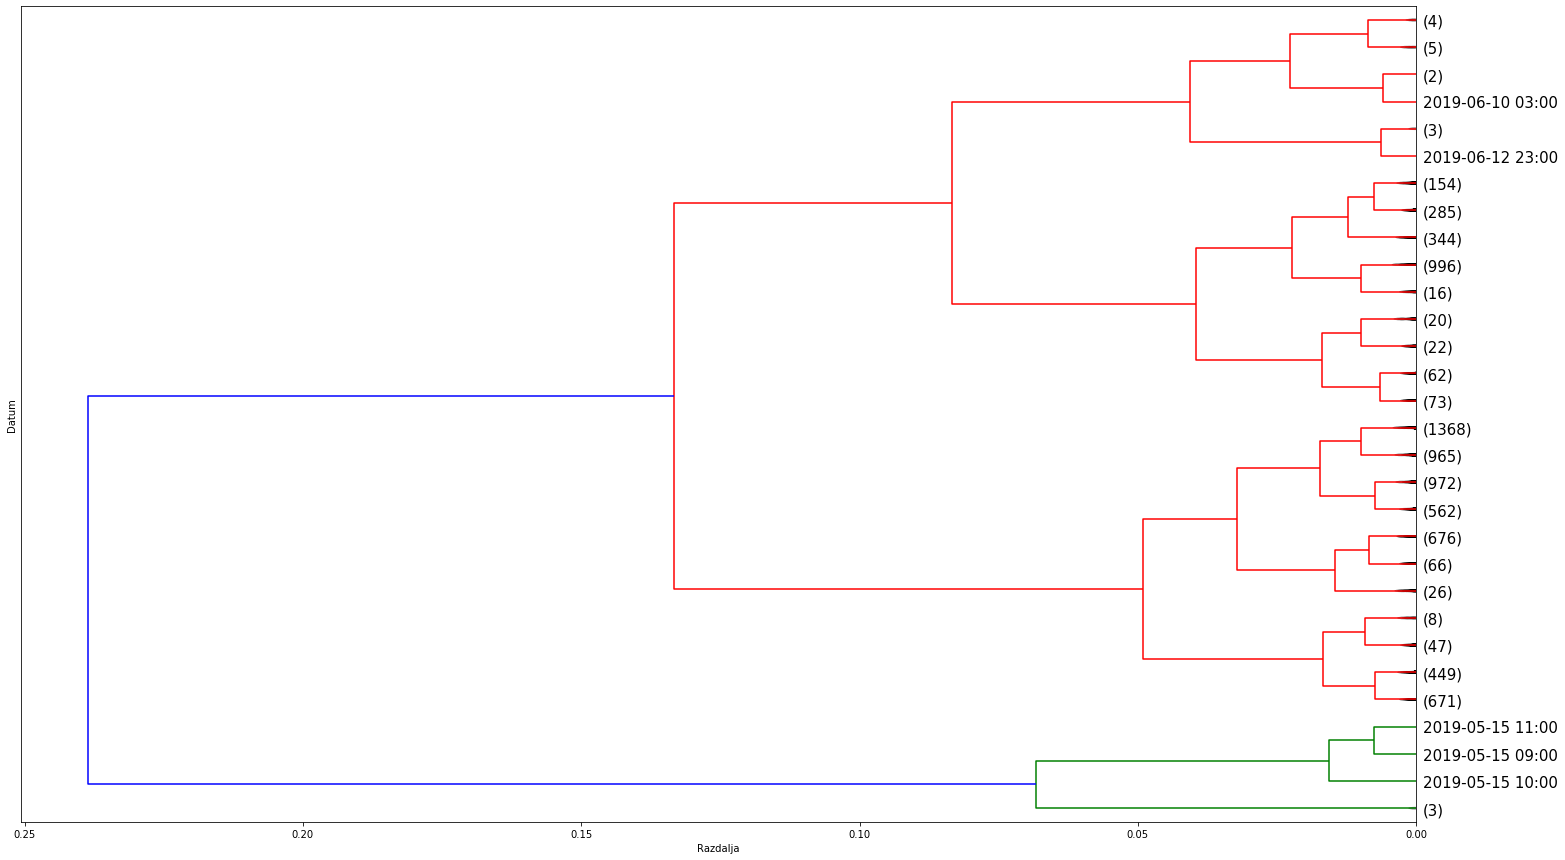

In [3]:
L = sch.linkage(matrix_X_all, method="complete", metric="cityblock")
plt.figure(figsize=(25, 15))

D  = sch.dendrogram(L, leaf_font_size=15, labels=matrix_all[:, 0], orientation="left", 
                        show_contracted=True, 
                        truncate_mode='lastp',  # last p merged clusters
                        p=30                    # show only the last p merged clusters
                       )
plt.xlabel("Razdalja")
plt.ylabel("Datum")
plt.show()

In [88]:
def find_optimal_t_cluster(L, matrix_fun, num_of_clusters):
    max_silhuete = [-1, 0]
    arr = []

    max_val = (floor(max(sch.maxdists(L)) * 100) / 100.0) * 0.66
    # print(max_val)
    t_f = max_val

    while(True):
        predictions = sch.fcluster(L, t=t_f, criterion="distance").ravel()
        score = round(silhouette_score(matrix_fun, predictions, metric="cityblock"), 3)
        arr.append((score, round(t_f, 4)))
        
        num_of_c = len(set(predictions))
        if num_of_c == num_of_clusters:
            max_silhuete[0] = score
            max_silhuete[1] = round(t_f, 4)
            break
        elif num_of_c < num_of_clusters:
            t_f = t_f - (t_f / 2)
        else:
            t_f = t_f + (t_f / 2)
        # print(t_f)

    print("The best value for t is t =", max_silhuete[1])
    return arr, t_f

In [90]:
arr_, t_best = find_optimal_t_cluster(L, matrix_X_all, 6)

predictions = sch.fcluster(L, t=t_best, criterion="distance").ravel()
print(set(predictions))

The best value for t is t = 0.0427
{1, 2, 3, 4, 5, 6}


In [91]:
def generate_sizes(class_dict):
    class_len_arr = []
    for i in class_dict:
        class_len_arr.append([i, len(class_dict[i])])
        
    class_sorted_arr = sorted(class_len_arr, key=lambda x: x[1])
    
    size_arr = []
    anomaly_koef = class_sorted_arr[len(class_sorted_arr) - 1][1] * 0.1

    for i in class_len_arr:
        if i[1] <= anomaly_koef:
            size_arr.append(200)
        else:
            size_arr.append(20)
        
    print(size_arr)
    return size_arr

In [104]:
def draw_classes(matrix, matrix_X, class_dict):
    color_array = ["yellowgreen", "coral", "dodgerblue", "red", "springgreen", "aqua", 
                   "mistyrose", "deeppink", "bisque", "indigo"]
    size_arr = generate_sizes(class_dict)

    fig = plt.figure(figsize=(18, 12), dpi= 100, facecolor='w')
    plt.plot(matrix[:, 0], matrix_X, color="blue")
    # s_anomaly = 100
    
    for num, element in enumerate(class_dict):
        plt.scatter([x[1] for x in class_dict[element]], [matrix_X[x[0]] for x in class_dict[element]], 
                    color=color_array[num], s=size_arr[num]) 

    plt.ylabel('Pressure in bar ?')
    plt.xlabel('Date')
    # plt.xticks([i for i in range(0,len(matrix), round(len(matrix)/12))], rotation=40)
    plt.xticks([])
    plt.rc('xtick',labelsize=8)
    plt.title('Time')
    # plt.savefig('blue_id.png')
    plt.show()


In [105]:
def main_function(start, end, data_fun, number_of_clusters):
    data_sel = data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]    
    # "2020-01-20 00:00", "2020-01-24 23:00"

    matrix = data_sel.reset_index().values
    matrix_X = matrix[:, 3:]        
    
    L = sch.linkage(matrix_X, method="complete", metric="cityblock")
    
    arr_, t_best = find_optimal_t_cluster(L, matrix_X, number_of_clusters)
    predictions = sch.fcluster(L, t=t_best, criterion="distance").ravel()
    
    class_dict = dict()

    for index, combined in enumerate(zip(matrix[:, 0], predictions)):
        value, predicted_class = combined
        if predicted_class not in class_dict:
            class_dict[predicted_class] = [(index, value)]
        else:
            class_dict[predicted_class].append((index, value))
            
    draw_classes(matrix, matrix_X, class_dict)

The best value for t is t = 0.0181
[20, 20, 20, 20, 200, 200, 200, 200, 200, 200]


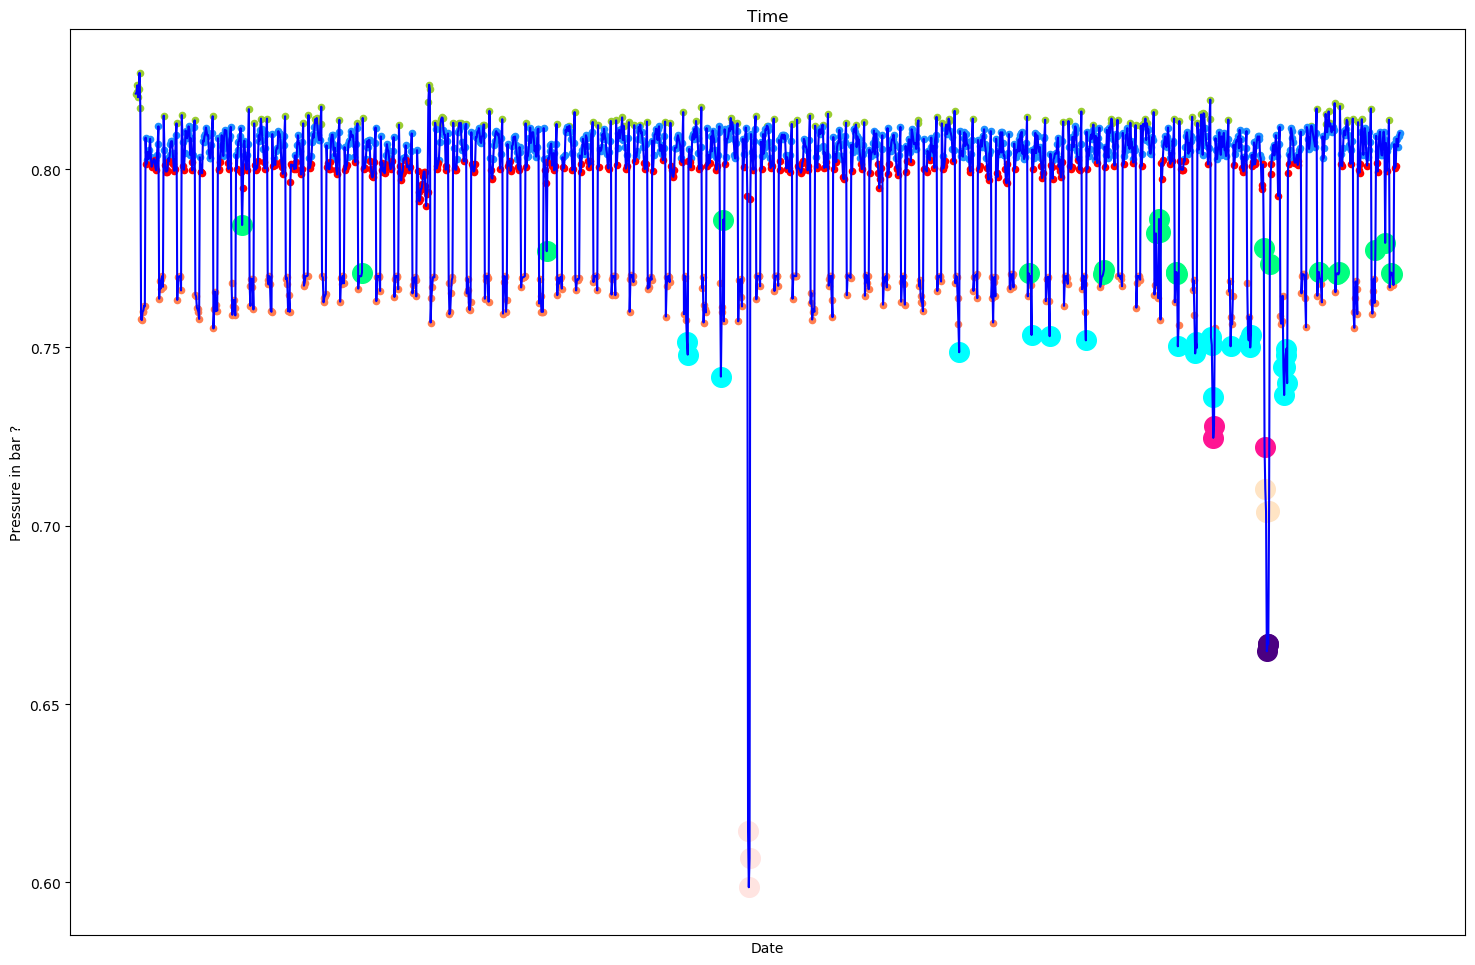

In [106]:
# selected_data(data_249, "2019-05-11 12:00:00", "2019-05-20 12:00:00")
# selected_data(data_249, "2019-05-11 12:00:00", "2020-06-13 12:00:00")

main_function("2019-04-11 12:00:00", "2019-06-20 12:00:00", data_249, 10)